In [1]:
cd ..

/home/mars/mount/src_aiai


In [2]:
import time
import tqdm 
import sparse


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.special import iv, jv
from scipy.sparse import *

In [3]:
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op, NUFFT_op_TF, old_NUFFT_op, old_NUFFT_op_TF, calculate_kaiser_bessel_coef
from src.visualisation import compare

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [4]:
uv = spider_sampling()

In [5]:
Nd = (256,256)
Kd = (512, 512)
Jd = (6,6)

## KB coefficients

In [6]:
gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize
kx = (uv[:,0] + np.pi) // gridsize
ky = (uv[:,1] + np.pi) // gridsize

In [7]:
c = calculate_kaiser_bessel_coef(k[0], 0)

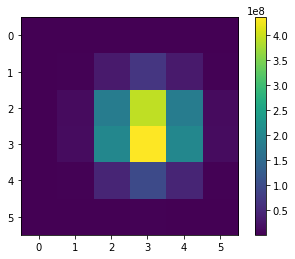

In [8]:
plt.imshow(c[-1].reshape(6,6))
plt.colorbar()

## NUFFT Operator

In [9]:
class Op():
    def __init__(self):
        pass
        # TODO select axes over which to perform fft (and padding operations)
        # TODO add scaling 
        # TODO check coeficient calculation
        
    def plan(self, uv, Nd, Kd, Jd):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        J = Jd[0] #np.linalg.norm(Jd)
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1))
#         self.scaling = 1

    def forward(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0], self.Nd[1])))))  # why divide on both sides?
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [10]:
op = NUFFT_op()
op.plan(uv, Nd=(256,256), Kd=(512,512), Jd=(6,6))

100%|█████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5169.72it/s]


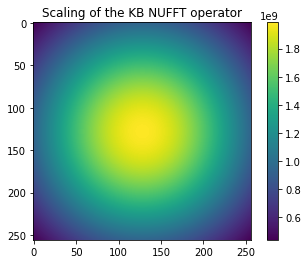

In [11]:
plt.imshow(op.scaling.real)
plt.title("Scaling of the KB NUFFT operator")
plt.colorbar()

## Compare Direct FT vs min-max NUFFT vs KB NUFFT



In [12]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*N)**2

In [13]:
# using (slow) non-uniform direct fourier transform
x_dirty_ndft = dft2(np.arange(-128,128), np.arange(-128,128), uv, np.ones(len(uv)))

  0%|                                                                           | 0/256 [00:00<?, ?it/s]<ipython-input-12-2d6e30a2d649>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
100%|█████████████████████████████████████████████████████████████████| 256/256 [00:49<00:00,  5.16it/s]


In [14]:
# old Min Max Nufft
old_op = old_NUFFT_op(uv)

In [15]:
y = np.ones((4440,1)) +0j

st = time.perf_counter()
x_dirty_kb = op.adj_op(y).real # kaiser bessel
t_kb = time.perf_counter() - st

st = time.perf_counter()
x_dirty_mm = old_op.adj_op(y).real # min max
t_mm = time.perf_counter() - st

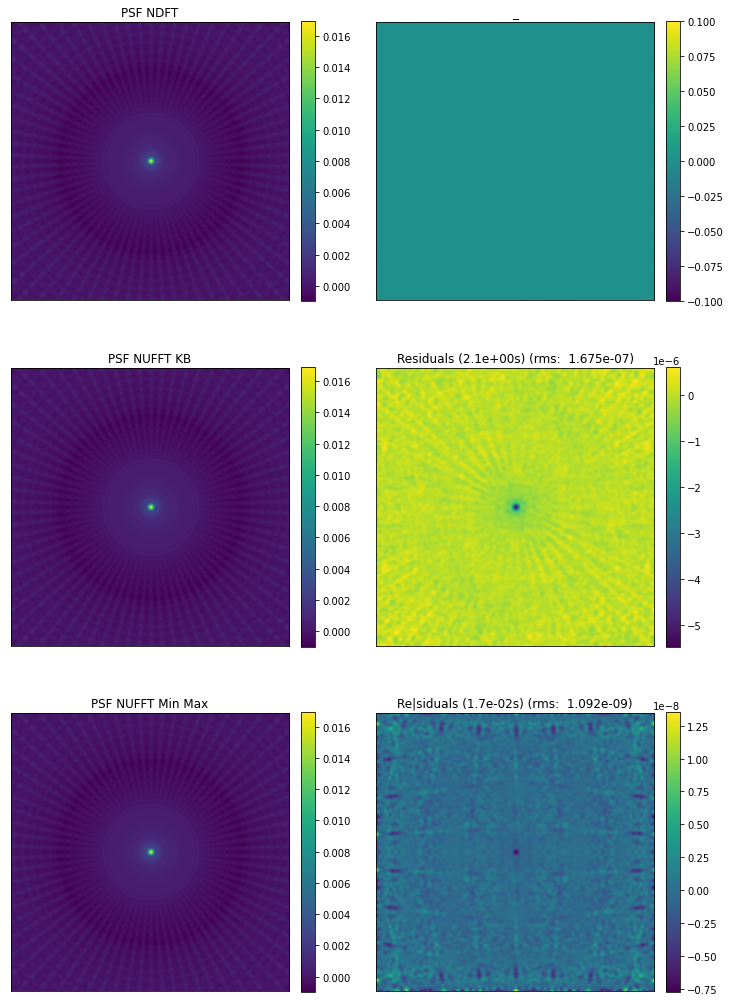

In [16]:
compare([
    x_dirty_ndft, np.zeros(Nd),
    x_dirty_kb, x_dirty_kb - x_dirty_ndft, 
    x_dirty_mm, x_dirty_mm - x_dirty_ndft], ncols=2, nrows=3, 
    titles=[
        "PSF NDFT", "_", 
        "PSF NUFFT KB", f"Residuals ({t_kb:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_kb))):.3e})",
        "PSF NUFFT Min Max", f"Residuals ({t_mm:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_mm))):.3e})"
    ], colorbar=True)

## TF numpyfunc vs TF Native

In [ ]:
print(tf.test.gpu_device_name())

In [18]:
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)
    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)

In [19]:
tf_kb = NUFFT_op_TF()
tf_kb.plan(uv, Nd, Kd, Jd, batch_size=20)

100%|█████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5406.64it/s]


In [20]:
tf_kb.interp_matrix.shape

TensorShape([20, 4440, 512, 512])

In [21]:
tf_kb2 = TF_nufft()
tf_kb2.plan(uv, Nd, Kd, Jd)

100%|█████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5012.55it/s]


In [37]:
y_tf = tf.cast(tf.convert_to_tensor(np.ones((20, 4440)) +0j), tf.complex64)

In [38]:
st = time.perf_counter()
x_dirty_tf_kb = tf_kb.adj_op(y_tf)
t_kb = time.perf_counter() - st

In [39]:
st = time.perf_counter()
x_dirty_tf_kb_np = tf_kb2.adjoint(y_tf) 
t_kb_np = time.perf_counter() - st

In [40]:
x_dirty_tf_kb = x_dirty_tf_kb.numpy().real[0]
x_dirty_tf_kb_np = x_dirty_tf_kb_np.numpy().real[0]

In [41]:
t_kb, t_kb_np

(3.170671814999878, 1.4014711279996845)

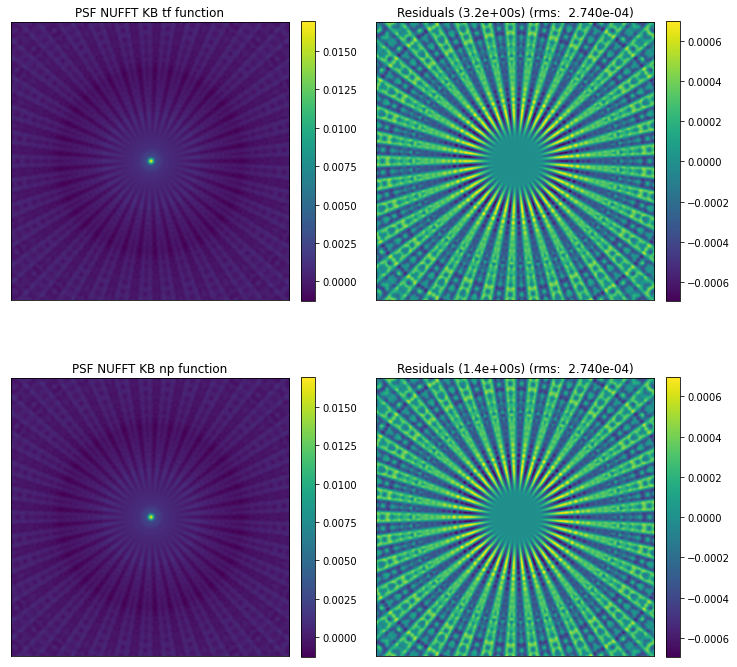

In [42]:
compare([
    x_dirty_tf_kb, x_dirty_tf_kb - x_dirty_ndft,
    x_dirty_tf_kb_np, x_dirty_tf_kb_np - x_dirty_ndft
    ], 
    nrows=2, ncols=2,
    titles=[
        "PSF NUFFT KB tf function", f"Residuals ({t_kb:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_tf_kb))):.3e})",
        "PSF NUFFT KB np function", f"Residuals ({t_kb_np:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_tf_kb_np))):.3e})"
    ], colorbar=True)